<a href="https://colab.research.google.com/github/darkknightraj/Protein-Secondary-Structure-using-RNN-and-LSTM/blob/main/Protein_Secondary_Structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Protein Secondary Structure using RNN and LSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Shivam

/content/drive/MyDrive/Shivam


(9078, 11)
2101


<ipython-input-5-474d89e52e99>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])


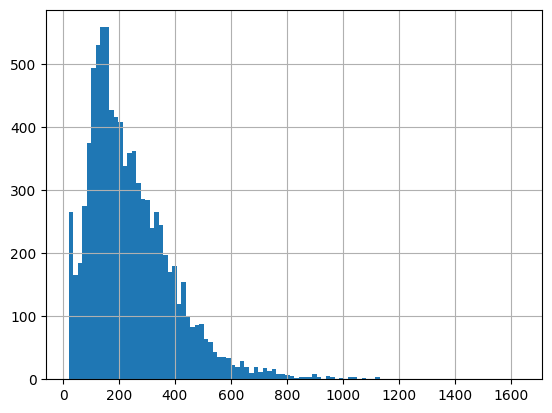

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/content/drive/MyDrive/Shivam/archive (15).zip (Unzipped Files)/2018-06-06-pdb-intersect-pisces.csv')
df.len.hist(bins=100)
print(df.shape)

def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(len(input_seqs))

In [6]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

((2101, 128), (2101, 128, 4))

In [9]:
!pip install --upgrade keras tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 26.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.1
    Uninstalling ml-dtypes-0.3.1:
      Successfully uninstalled ml-dtype

In [7]:
#from keras.models import Model, Input
from keras.layers import Input
from tensorflow.keras.layers import Input

from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

8301 4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 128)          1062528   
                                                                 
 bidirectional (Bidirection  (None, 128, 128)          98816     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 128, 4)            516       
 ributed)                                                        
                                                                 
Total params: 1161860 (4.43 MB)
Trainable params: 1161860 (4.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_test, y_test), verbose=1)


Epoch 1/25
10/10 [==============================] - 21s 1s/step - loss: 0.5713 - accuracy: 0.7286 - q3_acc: 0.6011 - val_loss: 0.6367 - val_accuracy: 0.6896 - val_q3_acc: 0.5351
Epoch 2/25
10/10 [==============================] - 8s 804ms/step - loss: 0.5241 - accuracy: 0.7562 - q3_acc: 0.6416 - val_loss: 0.6411 - val_accuracy: 0.6950 - val_q3_acc: 0.5432
Epoch 3/25
10/10 [==============================] - 10s 1s/step - loss: 0.4873 - accuracy: 0.7783 - q3_acc: 0.6742 - val_loss: 0.6490 - val_accuracy: 0.6992 - val_q3_acc: 0.5496
Epoch 4/25
10/10 [==============================] - 9s 852ms/step - loss: 0.4538 - accuracy: 0.7954 - q3_acc: 0.6993 - val_loss: 0.6630 - val_accuracy: 0.7011 - val_q3_acc: 0.5524
Epoch 5/25
10/10 [==============================] - 10s 1s/step - loss: 0.4218 - accuracy: 0.8138 - q3_acc: 0.7263 - val_loss: 0.6740 - val_accuracy: 0.7066 - val_q3_acc: 0.5606
Epoch 6/25
10/10 [==============================] - 8s 747ms/step - loss: 0.3922 - accuracy: 0.8301 - q3_a

1/1 [==============================] - 0s 53ms/step
training
---
Input: APTRQPSPVTRPWQHVDAIKEALSLLNDSTDTAAVMDETVEVVSEMFDSQEPTCLQTRLELYKQGLRGSLTSLTGSLTMMASHYKKHCPPTQETSCETQIITFKSFKENLKDFLFIIPFDCWEPVQK
Target: CCCCCCCCCCCCCHHHHHHHHHHHHHHCCCCCHHHHCCEEEEECCCCCCCCCCCHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCEEEEEHHHHHHHHHHHHHHCCCCCCCCCCC
Result: CCCCCCCCCCCCCHHHHHHHHHHHHHHCCCHHHHHHCCCCCEECCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCEEEEEEHHHHHHHHHHHHHCCCCCCCCCCC


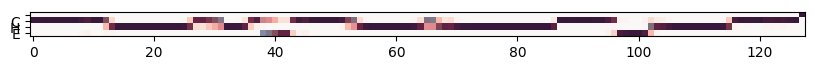

---
Input: QGQFFREIENLKEYFNASSPDVAKGGPLFSEILKNWKDESDKKIIQSQIVSFYFKLFENLKDNQVIQRSMDIIKQDMFQKFLNGSSEKLEDFKKLIQIPVDDLQIQRKAINELIKVMNDLS
Target: CCCHHHHHHHHHHHHCCCCHHHHCCCCCCHHHHHHCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCHHHHHHHHHHHHHHHCCCCHHHHHHHHHHHCCCCCCHHHHHHHHHCHHHHHHHCC
Result: CCCHHHHHHHHHHHHCCCCHHHHCCCCCHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHCCCCCCCHHHHHHHHHHHHHHHCCCCHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHC


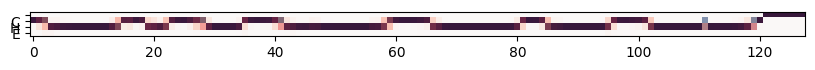

---
Input: EPAAAPAPTKEEVLLTEIRDLLKEQNNRS
Target: CCCCCCCCCHHHHHHHHHHHHHHHHHHHC
Result: CCCCCCCCHHHHHHHHHHHHHHHHHHHCC


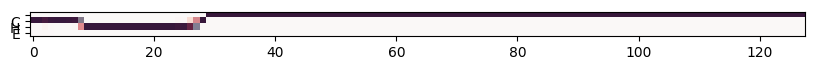

testing
---
Input: GSHMSASCGSGNFNKTAAKGVEFSAVAGDCIKYNKSSGTLQIGSWTGVASSYNITSGPQGITNTGNGWTTVANAANGDLYIKIVSASRSFNVKFDNW
Target: CCCCCCCCCCCCCCEECCCCCCEEECCCCEEEEEECCCCEEEEECCCCCEEEEECCCCCCEEECCCEEEEECCCCCEEEEEEEEEECCCEEEEEEEC
Result: CCCCCCEEECCCCCCCECCEEEEECCCCCEEEECCCCCCEEEEEEEEEEEEEECCCCCCCCCCCCHHHHEHHHCCCCCEEEEEEEEECEEEECCCCC


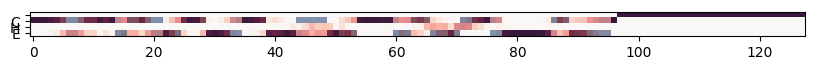

---
Input: MKKRSKARKETYSSYIYKVLKQTHPDTGISQKSMSILNSFVNDIFERIATEASKLAAYNKKSTISAREIQTAVRLILPGELAKHAVSEGTRAVTKYSSSTQA
Target: CCCCCCCCCCCCHHHHHHHHHHHCCCCEEEHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCEECHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHCCCCC
Result: CCCHCCCCCHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCCC


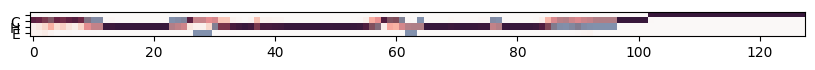

---
Input: GPSSPSVSDYTRANFGGLSEGEAQFSMTARALLDELTDLEGKLRAKLDRWDGDAQAAYWNYQKEWDAAAKDMQNVVAQLGVAIREAHDNYQAAERANTSIWAG
Target: CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCCCC
Result: CCCCCCCCCCCCCCCCCCCCCCHCHHHHHHCCCCCCCCHCCHHHHHCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCCCCCCCC


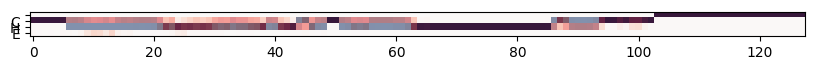

In [10]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()

revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])